# EDA

In [20]:
# install dependencies
!pip install kagglehub
!pip install --upgrade ipywidgets

import os
import shutil
from pathlib import Path
import kagglehub

dataset = "abdallahalidev/plantvillage-dataset"
local_dir = Path("plantvillage-dataset")

if not local_dir.exists():
    print("Downloading dataset for the first time…")
    # this returns the path to your kagglehub cache
    cached_path = kagglehub.dataset_download(dataset)
    # copy everything into your own folder
    shutil.copytree(cached_path, local_dir)
    print(f"Copied into {local_dir!r}")
else:
    print(f"Dataset already present in {local_dir!r}, skipping download.")

print("Path to dataset files:", local_dir.resolve())


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Dataset already present in PosixPath('plantvillage-dataset'), skipping download.
Path to dataset files: /home/gustavo/EDA_VpC2/plantvillage-dataset


In [ ]:
# remove the top-level directory created by kagglehub because it has a space in its name
!mv ./{local_dir}/plantvillage\ dataset/* ./{local_dir}  2>/dev/null || true
!rmdir ./{local_dir}/plantvillage\ dataset  2>/dev/null || true

# change files extension to lowecase
for file in local_dir.rglob("*.*"):
    if file.suffix.lower() != file.suffix:
        new_file = file.with_suffix(file.suffix.lower())
        file.rename(new_file)

import os
from pathlib import Path

print("Subdirectorios encontrados:")
for d in local_dir.iterdir():
    if d.is_dir():
        print(" ", d.name)


Subdirectorios encontrados:
  grayscale
  segmented
  color


Counter({'segmented': 54306, 'grayscale': 54303, 'color': 54303})


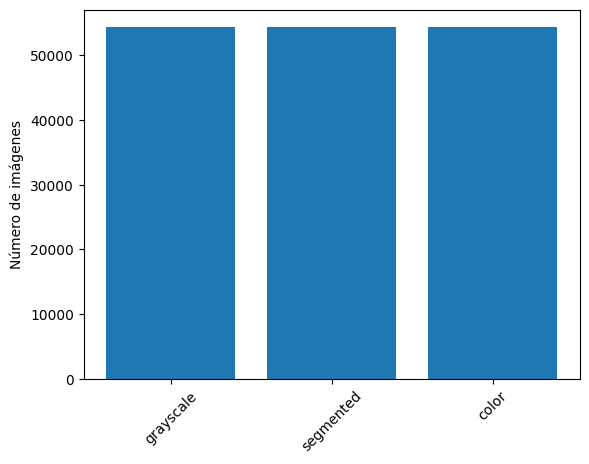

In [34]:
from collections import Counter

counts = Counter()
for cls_dir in local_dir.iterdir():
    if cls_dir.is_dir():
        img_files = [p for p in cls_dir.rglob("*.jpg")]
        n = len(img_files)  # ajusta la extensión si es necesario
        counts[cls_dir.name] = n

# Imprime y grafica
print(counts)
import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.show()


**Algunas muestras aleatorias**

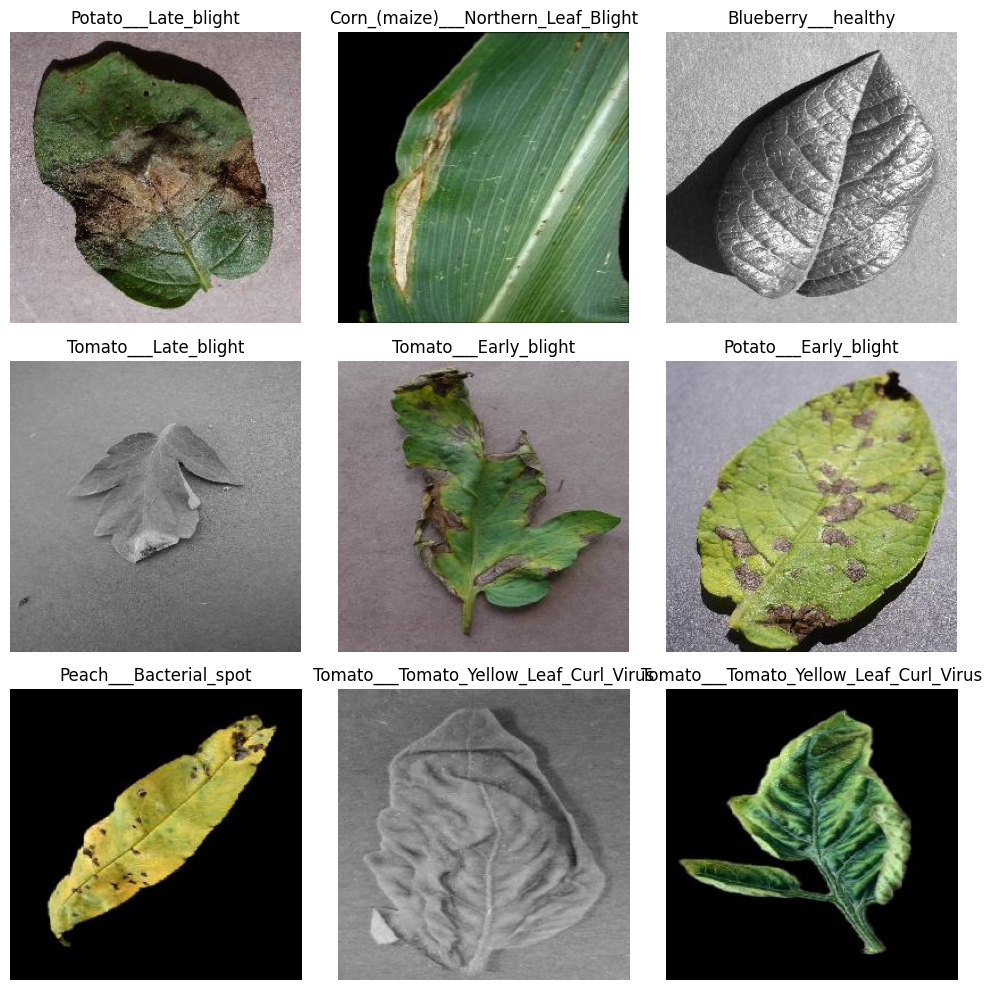

In [35]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_random_samples(n=9):
    fig, axes = plt.subplots(int(n**0.5), int(n**0.5), figsize=(10,10))
    axes = axes.flatten()
    all_files = list(local_dir.rglob("*.jpg"))
    samples = random.sample(all_files, n)
    for ax, img_path in zip(axes, samples):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_path.parent.name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_random_samples(9)

## Estadísticas de Pixel de las imágenes 

R: mean=95.0, std=61.4, min=0, max=255
G: mean=102.9, std=61.0, min=0, max=255
B: mean=89.0, std=62.0, min=0, max=255


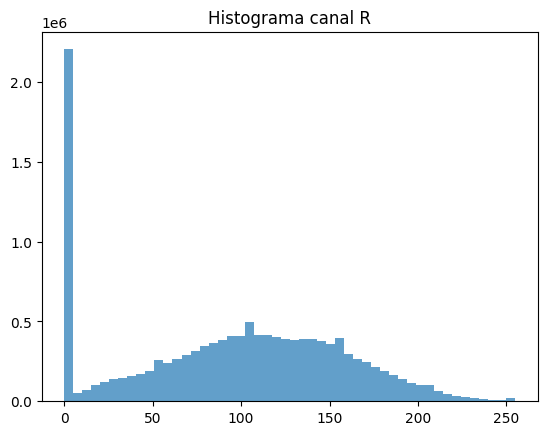

In [36]:

import numpy as np

# Toma una muestra para no saturar memoria
sample_paths = random.sample(list(local_dir.rglob("*.jpg")), 200)
pixels = []

for p in sample_paths:
    img = np.array(Image.open(p).convert("RGB"))
    pixels.append(img.reshape(-1, 3))

pixels = np.concatenate(pixels, axis=0)

for i, c in enumerate(["R","G","B"]):
    vals = pixels[:, i]
    print(f"{c}: mean={vals.mean():.1f}, std={vals.std():.1f}, min={vals.min()}, max={vals.max()}")
    
# Histograma de un canal
plt.hist(pixels[:,0], bins=50, alpha=0.7)
plt.title("Histograma canal R")
plt.show()


## Tamaños y relaciones de aspecto

Anchos: 256 256 256.0
Altos:  256 256 256.0


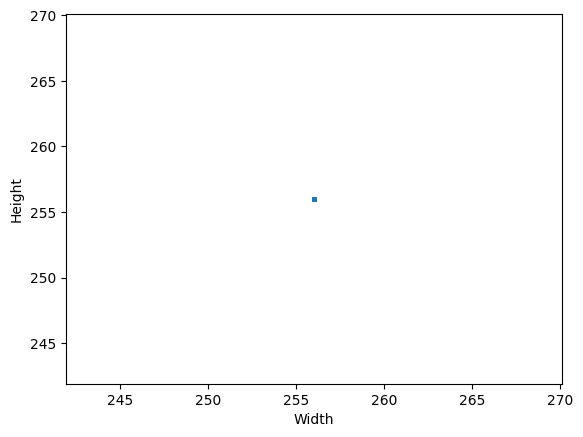

In [37]:
widths, heights = [], []
for p in sample_paths:
    img = Image.open(p)
    w,h = img.size
    widths.append(w); heights.append(h)

# Estadísticas
print("Anchos:", np.min(widths), np.max(widths), np.median(widths))
print("Altos: ", np.min(heights), np.max(heights), np.median(heights))

# Scatter aspect ratios
aspects = np.array(widths) / np.array(heights)
plt.scatter(widths, heights, s=5)
plt.xlabel("Width"); plt.ylabel("Height")
plt.show()

## Detección de outliers en el espacio de características

In [42]:
# Uncomment to install dependencies
# !pip install torch torchvision scikit-learn matplotlib

/home/gustavo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gustavo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


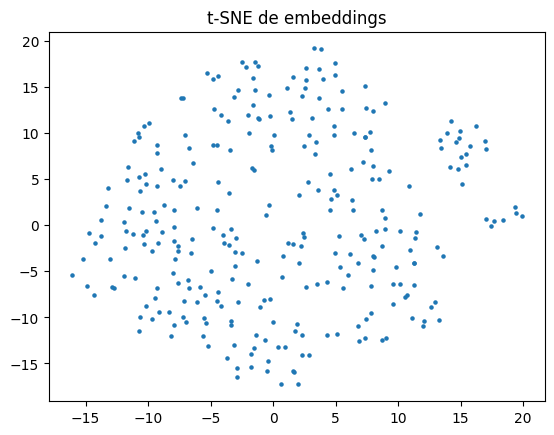

In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torchvision.models as models
import torchvision.transforms as T
import torch

# Extrae embeddings con una CNN pre-entrenada
model = models.resnet18(pretrained=True)
model.eval()
tr = T.Compose([T.Resize(224), T.CenterCrop(224), T.ToTensor()])

embs = []
for p in random.sample(list(local_dir.rglob("*.jpg")), 300):
    img = Image.open(p).convert("RGB")
    t = tr(img).unsqueeze(0)
    with torch.no_grad():
        e = model(t).squeeze().numpy()
    embs.append(e)

embs = np.stack(embs)

# Proyección con t-SNE
tsne = TSNE(n_components=2, perplexity=30)
proj = tsne.fit_transform(embs)

plt.scatter(proj[:,0], proj[:,1], s=5)
plt.title("t-SNE de embeddings")
plt.show()